### Data

In [23]:
import pandas as pd
import numpy as np

data = pd.read_csv("./bml-component-data.csv")

# Scale time column
data["timestamp"] /= 10000
data.head()

,ID,index,M1,M2,M3,M4,M5,timestamp,efficiency
0,CX-00,0,0.585,1.788,1.44,1.342,1.029,0.00,97.644
1,CX-00,0,0.585,1.788,1.44,1.342,1.029,0.01,90.796
2,CX-00,0,0.585,1.788,1.44,1.342,1.029,0.03,80.454
3,CX-00,0,0.585,1.788,1.44,1.342,1.029,0.04,83.102
4,CX-00,0,0.585,1.788,1.44,1.342,1.029,0.06,81.030


In [24]:
def pad(array, target_length):
    """Pads 1D array to target length using -1 constant as padding."""

    n_pad = target_length - array.shape[0]
    return np.pad(array, (0, n_pad), mode="constant", constant_values=[-1])

In [25]:
# Collect all values from each CX into one row and put timestamps and efficiencies into np arrays
data_grouped = data.groupby(["ID"]).agg(list)
data_grouped = data_grouped.map(np.array)

# Each row is exactly one CX
x = list(data_grouped["timestamp"])
y = list(data_grouped["efficiency"])

# Rows are ragged (rows aren't all the same length) so padding is required
max_obs = max([len(row) for row in y])

x_padded = np.array([pad(row, max_obs) for row in x])
y_padded = np.array([pad(row, max_obs) for row in y])

# Generate mask (True for actual values, False for padded values)
mask = x_padded != -1

### Baseline Model

Model the efficiency $y_i$ as a noisy exponential decay function $f_i$, with parameters $u_i$ and $v_i$:

$$y_i(t) = f_i(t) + \epsilon$$

$$f_i(t) = u_i \cdot \exp \left \{-v_i t \right \}$$

We omit the 10,000 divisor since we already divided the timestamp earlier.

In [ ]:
import numpyro as npr
import numpyro.distributions as dist
import jax.numpy as jnp

def model(t, y, mask):
    sigma = npr.sample("sigma", dist.HalfNormal(1))

    # Generate u_i and v_i for all CX components
    with npr.plate("cx-component", t.shape[0]):
        u = npr.sample("u", dist.Normal(90, 10))
        v = npr.sample("v", dist.Normal(5, 5))

    # Make predictions of f_i(t) then sample from normal dist with variance sigma to account for noise
    with npr.plate("observations", t.shape[1]):
        with npr.handlers.mask(mask=mask):
            f = u[:, jnp.newaxis] * jnp.exp(-v[:, jnp.newaxis] * t)
            npr.sample("obs", dist.Normal(f, sigma), y)

In [27]:
from jax import random
from numpyro.infer import MCMC, NUTS


seed = 0
nuts_kernel = NUTS(model)
mcmc = MCMC(nuts_kernel, num_warmup=500, num_samples=1000)
rng_key = random.PRNGKey(seed)
mcmc.run(rng_key, t=x_padded, y=y_padded, mask=mask)
mcmc.print_summary()

C:\Users\jayde\AppData\Local\Temp\ipykernel_4872\1977394780.py:9: UserWarning: Missing a plate statement for batch dimension -2 at site 'obs'. You can use `numpyro.util.format_shapes` utility to check shapes at all sites of your model.
  mcmc.run(rng_key, t=x_padded, y=y_padded, mask=mask)
sample: 100%|██████████| 1500/1500 [00:03<00:00, 405.80it/s, 31 steps of size 1.84e-01. acc. prob=0.86] 


                mean       std    median      5.0%     95.0%     n_eff     r_hat
     sigma      5.08      0.13      5.07      4.86      5.30   1967.06      1.00
      u[0]     91.95      2.53     91.83     87.70     95.89   2349.07      1.00
      u[1]     91.77      2.72     91.87     87.61     96.47   1709.10      1.00
      u[2]     92.65      2.79     92.73     88.19     97.43   2607.90      1.00
      u[3]     91.27      4.11     91.11     84.69     98.37   1820.16      1.00
      u[4]     88.60      4.49     88.42     81.05     95.59    924.80      1.00
      u[5]     97.59      6.84     97.83     86.19    108.05   1639.14      1.00
      u[6]     91.26      4.52     91.34     83.32     98.23   1511.57      1.00
      u[7]     90.80      4.52     90.76     83.61     97.93   2536.32      1.00
      u[8]    102.62      3.99    102.57     96.08    109.09   1408.78      1.00
      u[9]     89.08      4.37     89.03     82.33     95.95   2375.45      1.00
     u[10]    100.28      3

In [30]:
samples = mcmc.get_samples()

jnp.abs(samples["v"]).mean()

Array(3.3227026, dtype=float32)

### Show some example plots to make sure its working

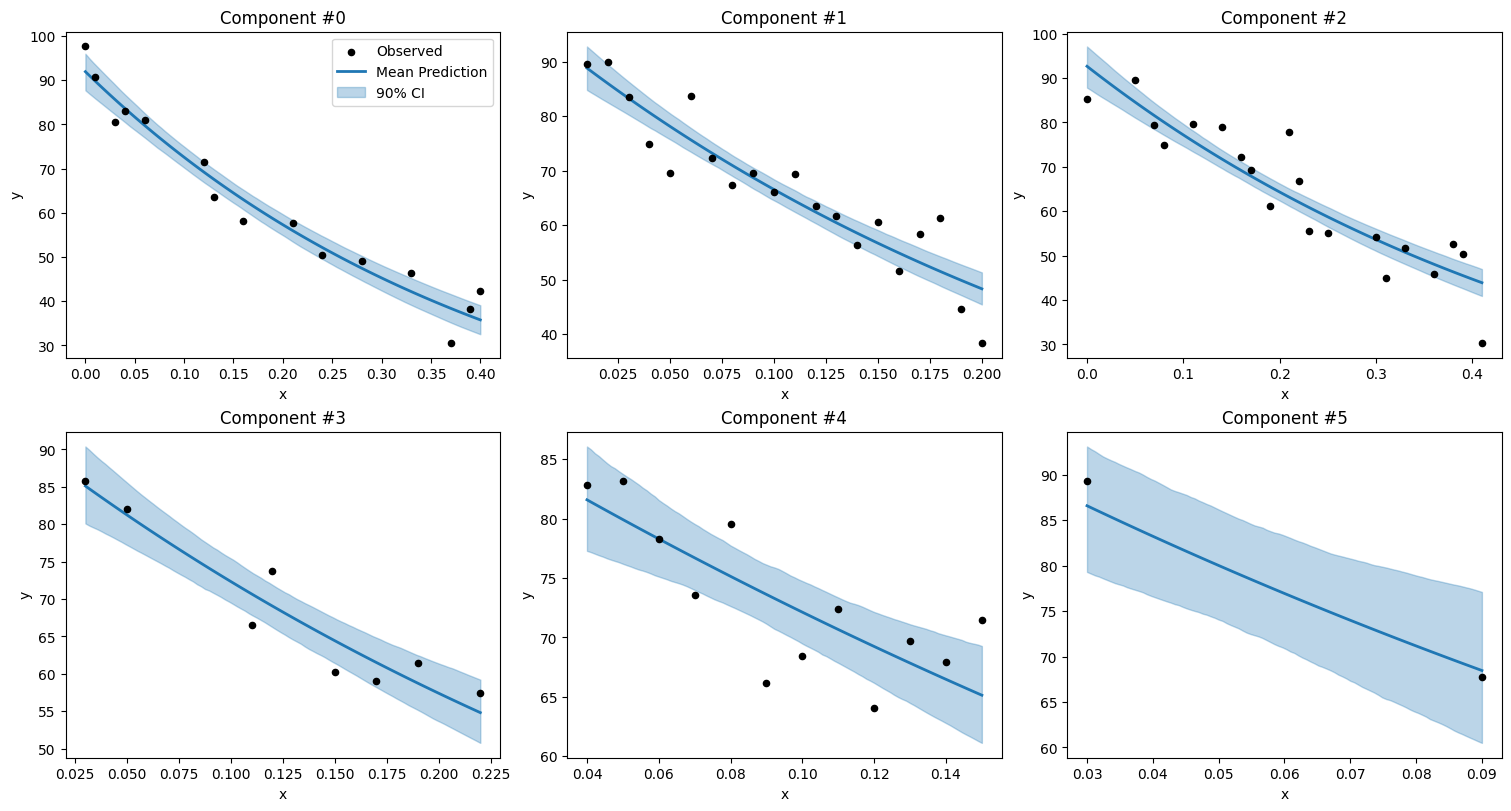

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import jax.numpy as jnp

def plot_component_fits(mcmc, x_data, y_data, mask, num_plots=9):
    """
    Plots the observed data vs the inferred decay curve.
    
    Args:
        mcmc: The fitted NumPyro MCMC object.
        x_data: The padded x input array (N, max_len).
        y_data: The padded y observed array (N, max_len).
        mask: The boolean mask array (N, max_len).
        num_plots: How many random components to visualize.
    """
    # 1. Get posterior samples
    samples = mcmc.get_samples()
    u_samples = samples['u'] # Shape: (num_samples, 75)
    v_samples = samples['v'] # Shape: (num_samples, 75)
    
    # 2. Setup the plot grid
    cols = 3
    rows = (num_plots + cols - 1) // cols
    fig, axes = plt.subplots(rows, cols, figsize=(15, 4 * rows), constrained_layout=True)
    axes = axes.flatten()
    
    # Select indices to plot (e.g., first few or random)
    indices_to_plot = np.arange(min(num_plots, x_data.shape[0]))
    
    for i, ax in zip(indices_to_plot, axes):
        # --- A. Prepare Real Data ---
        # Apply mask to get only real observations for this component
        valid_idx = mask[i].astype(bool)
        x_real = x_data[i][valid_idx]
        y_real = y_data[i][valid_idx]
        
        # Sort X for cleaner plotting of lines
        sort_order = np.argsort(x_real)
        x_real = x_real[sort_order]
        y_real = y_real[sort_order]

        # --- B. Generate Prediction Curve ---
        # Create a smooth x-axis for the line plot
        x_smooth = jnp.linspace(x_real.min(), x_real.max(), 100)
        
        # Get samples specifically for component 'i'
        u_i = u_samples[:, i] # Shape: (num_samples,)
        v_i = v_samples[:, i]
        
        # Calculate curve for ALL samples: y = u * exp(-v * x)
        # Broadcasting: (samples, 1) * exp(-(samples, 1) * (100,))
        predictions = u_i[:, None] * jnp.exp(-v_i[:, None] * x_smooth)
        
        # Calculate Mean and 90% Credible Interval (CI)
        mean_pred = jnp.mean(predictions, axis=0)
        hpdi_low = jnp.percentile(predictions, 5, axis=0)
        hpdi_high = jnp.percentile(predictions, 95, axis=0)

        # --- C. Plotting ---
        # 1. Plot real data points
        ax.scatter(x_real, y_real, color='black', s=20, label='Observed', zorder=3)
        
        # 2. Plot Mean Line
        ax.plot(x_smooth, mean_pred, color='tab:blue', lw=2, label='Mean Prediction')
        
        # 3. Plot Uncertainty Band
        ax.fill_between(x_smooth, hpdi_low, hpdi_high, color='tab:blue', alpha=0.3, label='90% CI')
        
        ax.set_title(f"Component #{i}")
        ax.set_xlabel("x")
        ax.set_ylabel("y")
        
        # Only show legend on the first plot to avoid clutter
        if i == 0:
            ax.legend()

    # Hide unused subplots
    for j in range(i + 1, len(axes)):
        axes[j].axis('off')
        
    plt.show()

plot_component_fits(mcmc, x_padded, y_padded, mask, num_plots=3)